In [1]:
import numpy as np  
import matplotlib.pyplot as plt
from lambeq.backend.quantum import Ry, Diagram, Bra, Rx, Rz
from util import data_loader, gen_bloch_states, get_observable, plot_scatter, plot_dist, plot_heatmap
from contextuality.model import chsh_scenario, Model
import seaborn as sns
from funcs import calc_eoe, calc_neg, state2dense, gen_basis, calc_violation, convert_dist, convert_phase, normalise, partial_trace, log_neg
import pandas as pd

In [2]:
x_basis = gen_basis(np.pi/2, 0)
y_basis = gen_basis(np.pi/2, np.pi/2)
z_basis = gen_basis()

onb1 = gen_basis(np.pi/2, np.pi/8)[0]
onb2 = gen_basis(np.pi/2, 5*np.pi/8)[0]

contexts_cc = {'ab': np.kron(onb1, onb1), 
               'aB': np.kron(onb1, onb2),  
               'Ab': np.kron(onb2, onb1),  
               'AB': np.kron(onb2, onb2)}
_observables = {'A': (get_observable('ONB1', np.pi/2, np.pi/8), get_observable('ONB2', np.pi/2, 5*np.pi/8)), 'B': (get_observable('ONB1', np.pi/2, np.pi/8), get_observable('ONB2', np.pi/2, 5*np.pi/8))}
observables = {'A': (get_observable('a1', 0, 0), get_observable('a2', np.pi/4, 0)), 'B': (get_observable('b1', np.pi/8, 0), get_observable('b2', 5*np.pi/8, 0))}
contexts_max = {'ab': np.kron(observables['A'][0].array, observables['B'][0].array),
                'aB': np.kron(observables['A'][0].array, observables['B'][1].array), 
                'Ab': np.kron(observables['A'][1].array, observables['B'][0].array), 
                'AB': np.kron(observables['A'][1].array, observables['B'][1].array)}

# bell_state = np.array([1,0,0,1]) * 1/(2**0.5)
# prs1 = abs(contexts_cc['ab'] @ bell_state)**2
# prs2 = abs(contexts_cc['aB'] @ bell_state)**2
# prs3 = abs(contexts_cc['Ab'] @ bell_state)**2
# prs4 = abs(contexts_cc['AB'] @ bell_state)**2
# Model(chsh_scenario(), convert_dist([prs1, prs2, prs3, prs4])).contextual_fraction()
subj_obj_pairs = [('heart', 'blood'), ('sailors', 'boats'), ('students', 'books'), ('knife', 'fence'),
                  ('storm', 'flight'), ('bee', 'flower'), ('birds', 'seeds'), ('police', 'criminals'), 
                  ('people', 'government'), ('sniper', 'terrorist')]

In [8]:
model_path = {'d_ref': 'runs/disjoint_ref_130E/best_model.lt', 
              'd_nref': 'runs/disjoint_noref_140E/best_model.lt',
              's_ref': 'runs/spider_ref_200E/best_model.lt', 
              's_nref': 'runs/spider_noref_50E/best_model.lt'}

diagram_path = {'rref': 'dataset/diagrams/diags_right_ref.pkl',
                'wref': 'dataset/diagrams/diags_wrong_ref.pkl',
                'nref': 'dataset/diagrams/diags_no_ref.pkl'}

data_path = {'d_rref': 'dataset/new_data_pkl/open-wire_right_ref.pkl',
             'd_wref': 'dataset/new_data_pkl/open-wire_wrong_ref.pkl',
             'd_nref': 'dataset/new_data_pkl/open-write_no_ref.pkl',
             's_rref': 'dataset/new_data_pkl/spider_right_ref.pkl',
             's_wref': 'dataset/new_data_pkl/spider_wrong_ref.pkl',
             's_nref': 'dataset/new_data_pkl/spider_no_ref.pkl',}

In [10]:
ow_rref = data_loader(chsh_scenario())
ow_rref.load_data(data_path['d_rref'])
ow_wref = data_loader(chsh_scenario())
ow_wref.load_data(data_path['d_wref'])
ow_nref = data_loader(chsh_scenario())
ow_nref.load_data(data_path['d_nref'])

s_rref = data_loader(chsh_scenario())
s_rref.load_data(data_path['d_rref'])
s_wref = data_loader(chsh_scenario())
s_wref.load_data(data_path['d_wref'])
s_nref = data_loader(chsh_scenario())
s_nref.load_data(data_path['d_nref'])

In [122]:
df = pd.read_csv('dataset/original_data/test.csv')

In [143]:
def get_ref_type(df1, df2, ref_type='right'):
    subj_arr = ['heart', 'sailors', 'students', 'knife', 'storm', 'bee', 'birds', 'police', 'people', 'sniper']
    #obj_arr = ['blood', 'boats', 'books', 'fence', 'flight', 'flower', 'seeds', 'criminals', 'government', 'terrorist']
    
    subj, obj = [], []
    i = j = 0
    while i < len(df1):
        if df1.iloc[i]['Sentence'].split('.')[0] == df2.iloc[j]['sentence1']:
            ref = df2.iloc[j]['referent']
            if ref_type != 'right':
                ref = df2.iloc[j]['wrong_referent']
            if ref in subj_arr:
                subj.append(i)
            else:
                obj.append(i)
            i += 1
            j += 1
        else:
            j += 1 
    return subj, obj

In [155]:
s_subj_right, s_obj_right = get_ref_type(s_rref.data, df)
s_subj_wrong, s_obj_wrong = get_ref_type(s_wref.data, df, 'wrong')
ow_subj_right, ow_obj_right = get_ref_type(ow_rref.data, df, 'wrong')
ow_subj_wrong, ow_obj_wrong = get_ref_type(ow_wref.data, df, 'wrong')

In [167]:
ssr = s_rref.data.iloc[s_subj_right]
sor = s_rref.data.iloc[s_obj_right]
ssw = s_wref.data.iloc[s_subj_wrong]
sow = s_wref.data.iloc[s_obj_wrong]
owsr = ow_rref.data.iloc[ow_subj_right]
owor = ow_rref.data.iloc[ow_obj_right]
owsw = ow_wref.data.iloc[ow_subj_wrong]
owow = ow_wref.data.iloc[ow_obj_wrong]

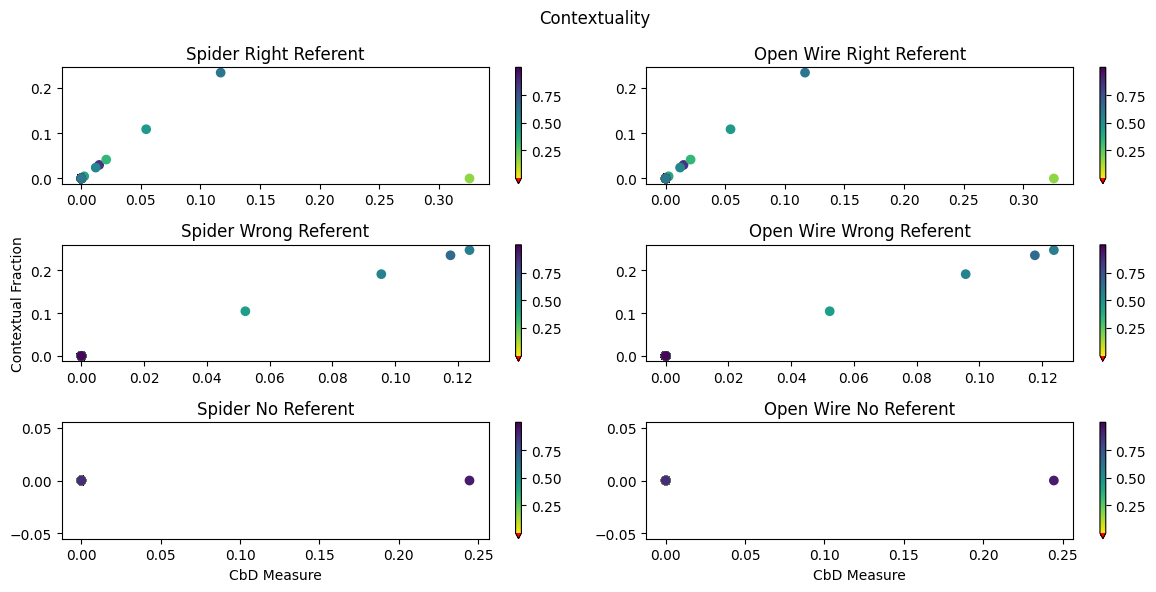

In [193]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(3,2,1)
dat = np.array(s_rref.data['CbD'])
dat[dat < 0] = 0
plot_scatter(ax, s_rref.data['CF'], dat, s_rref.data['Entropy'])
ax.set_title("Spider Right Referent")

ax = fig.add_subplot(3,2,2)
dat = np.array(ow_rref.data['CbD'])
dat[dat < 0] = 0
plot_scatter(ax, ow_rref.data['CF'], dat, ow_rref.data['Entropy'])
ax.set_title("Open Wire Right Referent")

ax = fig.add_subplot(3,2,3)
dat = np.array(s_wref.data['CbD'])
dat[dat < 0] = 0
plot_scatter(ax, s_wref.data['CF'], dat, s_wref.data['Entropy'])
ax.set_ylabel("Contextual Fraction")
ax.set_title("Spider Wrong Referent")

ax = fig.add_subplot(3,2,4)
dat = np.array(ow_wref.data['CbD'])
dat[dat < 0] = 0
plot_scatter(ax, ow_wref.data['CF'], dat, ow_wref.data['Entropy'])
ax.set_title("Open Wire Wrong Referent")

ax = fig.add_subplot(3,2,5)
dat = np.array(s_nref.data['CbD'])
dat[dat < 0] = 0
plot_scatter(ax, s_nref.data['CF'], dat, s_nref.data['Entropy'])
ax.set_xlabel("CbD Measure")
ax.set_title("Spider No Referent")

ax = fig.add_subplot(3,2,6)
dat = np.array(ow_nref.data['CbD'])
dat[dat < 0] = 0
plot_scatter(ax, ow_nref.data['CF'], dat, ow_nref.data['Entropy'])
ax.set_xlabel("CbD Measure")
ax.set_title("Open Wire No Referent")

fig.suptitle("Contextuality")
fig.tight_layout()
fig.savefig("figures/new_figs/cnxt")
#fig.supxlabel("CbD Measure")
#fig.supylabel("Contextual Fraction")

In [216]:
def plot_hist(fig, data):
    sns.histplot(data, ax=fig)

In [256]:
s_rref.data['Entropy'][s_rref.data['CF'] > 0]

107     0.858461
464     0.539785
727     0.458617
1623    0.412217
1881    0.171319
1991    0.339607
2293    0.610740
Name: Entropy, dtype: float64

In [258]:
s_rref.data['CF'][s_rref.data['CF'] > 0]

107     0.014947
464     0.012028
727     0.054399
1623    0.002390
1881    0.325828
1991    0.020869
2293    0.116930
Name: CF, dtype: float64

In [259]:
s_rref.data['Entropy'][s_rref.data['CbD'] > 0]

107     0.858461
464     0.539785
727     0.458617
1623    0.412217
1991    0.339607
2293    0.610740
Name: Entropy, dtype: float64